In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import argparse
import time, sys
import re
import generate_lexica
import importlib
importlib.reload(generate_lexica)
import pickle
from transformers import XLMRobertaTokenizer, AutoTokenizer

SHAP_FLAG = "XLM"
lexica_dict = generate_lexica.generate_lexica()

/home/shreyah/.conda/envs/politeness/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prefix = ""
if(SHAP_FLAG == "XLM"):
    prefix = "shapley/xlm_shap_values/"
    tokenizer_en = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
    tokenizer_es = tokenizer_en
    tokenizer_ja = tokenizer_en
    tokenizer_zh = tokenizer_en
elif(SHAP_FLAG == "MONO"):
    prefix = "shapley/monolingual_shap_values/"
    tokenizer_en = AutoTokenizer.from_pretrained('roberta-base')
    tokenizer_es = AutoTokenizer.from_pretrained('bertin-project/bertin-roberta-base-spanish')
    tokenizer_ja = AutoTokenizer.from_pretrained('rinna/japanese-roberta-base', use_fast=False)
    tokenizer_ja.do_lower_case = True
    tokenizer_zh = AutoTokenizer.from_pretrained('hfl/chinese-roberta-wwm-ext')
else:
    raise Exception("SHAP_FLAG must be XLM or MONO")

### FUNCTIONS

In [3]:
def read_shap_values_pickle(file_path):
    with open(file_path, 'rb') as file:
        shap_values = pickle.load(file)
    return shap_values

def get_token_level_shapley_values(shap_filepath, tokenizer, language):
    shap_pickle = read_shap_values_pickle(shap_filepath)
    token_level_shapley_values = []
    utterances = []

    shap_data = shap_pickle.data
    shap_values = shap_pickle.values
    shap_base = shap_pickle.base_values

    for idx in tqdm(range(len(shap_data))):
        tokens = shap_data[idx]
        values = shap_values[idx]
        base = shap_base[idx]
        # divide base amongst all tokens
        base_add = base/len(tokens)
        values = [v + base_add for v in values]
        
        if(language == "Spanish" and SHAP_FLAG == "MONO"):
            processed_tokens = []
            #replace all accented characters in spanish with non-accented
            to_replace = ["á", "é", "í", "ó", "ú", "ü", "ñ"]
            replace_with = ["a", "e", "i", "o", "u", "u", "n"]
            for token in tokens:
                for i in range(len(to_replace)):
                    token = token.replace(to_replace[i], replace_with[i])
                processed_tokens.append(token)
            tokens = processed_tokens
        
        utterance_string = tokenizer.convert_tokens_to_string(tokens)
        
        if(language == "Chinese" and SHAP_FLAG == "MONO"):
            utterance_string = utterance_string.replace(" ", "")
        
        utterances.append(utterance_string)
        token_level_shapley_values.append([tokens, values, base])
    return utterances, token_level_shapley_values

def process_tokens(token_list):
    #remove all spaces and punctuation from token that are added by tokenizer
    to_replace = [" ", "_", "▁", ".", "\n", "Ġ"]
    #ensure utf-8 encoding
    token_list = [x.encode('utf-8').decode('utf-8') for x in token_list]
    for r in to_replace:
        token_list = [x.replace(r, "") for x in token_list]
    #make all lowercase
    token_list = [str(x).lower() for x in token_list]
    return token_list

def get_start_end_idxs(shap_tokens, match_tokens):
    start_idx = -1
    end_idx = -1
    for j in range(len(shap_tokens)):
        if(shap_tokens[j] == match_tokens[0]):
            if(shap_tokens[j:j+len(match_tokens)] == match_tokens):
                start_idx = j
                end_idx = j+len(match_tokens)
    return start_idx, end_idx

def get_start_end_idxs_contains(shap_tokens, match_tokens):
    start_idx = -1
    end_idx = -1
    for j in range(len(shap_tokens)):
        if(match_tokens[0] in shap_tokens[j]):
            start_idx = j
            end_idx = j+len(match_tokens)
    return start_idx, end_idx

def get_start_end_idxs_contains_reverse(shap_tokens, match_tokens):
    start_idx = -1
    end_idx = -1
    match = "".join(match_tokens)
    try:
        for j in range(len(shap_tokens)):
            word = "".join(shap_tokens[j:(j+len(match_tokens)+2)])
            if(match in word):
                start_idx = j
                end_idx = j+len(match_tokens)+2
            word = "".join(shap_tokens[j:(j+len(match_tokens)+1)])
            match = "".join(match_tokens)
            if(match in word):
                start_idx = j
                end_idx = j+len(match_tokens)+1    
            word = "".join(shap_tokens[j:j+len(match_tokens)])
            if(match in word):
                start_idx = j
                end_idx = j+len(match_tokens)  
    except:
        print("error finding idxs for %s in %s" % (match_tokens, shap_tokens))
    return start_idx, end_idx

def get_all_strategies_token_level(language, detected_strategies, shap_object, tokenizer):  
    assert(len(detected_strategies) == len(shap_object))
    strategy_importances = { x:[] for x in lexica_dict[language].keys()}
    strategy_counts = { x:0 for x in lexica_dict[language].keys()}
    strategy_insights = { x:{} for x in lexica_dict[language].keys()}

    internal_corr = { x:{} for x in lexica_dict[language].keys()}

    for i, sentence_strategies in tqdm(enumerate(detected_strategies)):
        for strat, matches in sentence_strategies.items():
            for match in matches:
                if(match == ""): continue
                shap_tokens = process_tokens(shap_object[i][0])
                shap_values = shap_object[i][1]
                #process tokens
                shap_tokens = [x.replace(" ","") for x in shap_tokens if x != ""]               
                #get start and end index of where match is in shap_tokens
                if(type(match) != str):
                    match = match[1]
                match_tokens = process_tokens(tokenizer.tokenize(match))
                start_idx, end_idx = get_start_end_idxs(shap_tokens, match_tokens)
                if(start_idx == -1 or end_idx == -1):
                    if(language=="English" or language=="Spanish"):
                        if(SHAP_FLAG == "MONO"):
                            match_tokens = process_tokens(tokenizer.tokenize("  " + match + " "))[1:-1]
                        else:
                            match_tokens = process_tokens(tokenizer.tokenize("(" + match + ")"))[1:-1]
                        start_idx, end_idx = get_start_end_idxs(shap_tokens, match_tokens)
                    else:
                        start_idx, end_idx = get_start_end_idxs_contains(shap_tokens, match_tokens)
                if(start_idx == -1 or end_idx == -1):
                    if((language=="English" or language=="Spanish") and SHAP_FLAG == "MONO"):               
                        match_tokens = process_tokens(["".join(tokenizer.tokenize(match))])
                        start_idx, end_idx = get_start_end_idxs(shap_tokens, match_tokens)
                if(start_idx == -1 or end_idx == -1):
                    # print("no match for %s in %s" % (match_tokens, shap_tokens))  
                    continue

                total_value = np.sum(shap_values[start_idx:end_idx])
                strategy_importances[strat].append(total_value)
                strategy_counts[strat] += 1
                try:
                    strategy_insights[strat][match.lower()].append(total_value)
                    internal_corr[strat][match.lower()].append(np.sum(shap_values) + shap_object[i][2])
                except:
                    strategy_insights[strat][match.lower()] = []
                    strategy_insights[strat][match.lower()].append(total_value)
                    internal_corr[strat][match.lower()] = []
                    internal_corr[strat][match.lower()].append(np.sum(shap_values) + shap_object[i][2])
    return strategy_importances, strategy_counts, strategy_insights, internal_corr

def detect_politeness_strategy(sentences, politeness_strategies):
    count_no_strategies = 0
    sentence_strategies = []
    for sentence in sentences:
        strategies = {}
        for strategy, pattern in politeness_strategies.items():
                if pattern.search(sentence):
                    strategies[strategy] = pattern.findall(sentence)
        sentence_strategies.append(strategies)
        if(len(strategies) == 0):
            count_no_strategies += 1
    print("Number of sentences with no strategies: %d" % count_no_strategies)
    return sentence_strategies

def process_strategy_results(strategies):
    values = strategies[0]
    counts = strategies[1]
    values_avg = {}
    if("please_start" in values.keys()):
        values["please"] = [x for x in values["please"] if x not in values["please_start"]]
        values["please"] = [x for x in values["please"] if x not in values["please_start"]]
    for key in values.keys():
        if(counts[key] > 0):
            avg = np.mean(values[key])
            if(abs(avg) < 0.05): avg *= 2
            values_avg[key] = avg
    return values_avg

#### Get Strategies across Utterances

In [4]:
utterances_en, shap_en = get_token_level_shapley_values(prefix+"english.p", tokenizer_en, "English")
detected_strategies_en = detect_politeness_strategy(utterances_en, lexica_dict["English"])
strategies_english_raw = get_all_strategies_token_level("English", detected_strategies_en, shap_en, tokenizer_en)

utterances_es, shap_es = get_token_level_shapley_values(prefix+"spanish.p", tokenizer_es, "Spanish")
detected_strategies_es = detect_politeness_strategy(utterances_es, lexica_dict["Spanish"])
strategies_spanish_raw = get_all_strategies_token_level("Spanish", detected_strategies_es, shap_es, tokenizer_es)

utterances_ja, shap_ja = get_token_level_shapley_values(prefix+"japanese.p", tokenizer_ja, "Japanese")
detected_strategies_ja = detect_politeness_strategy(utterances_ja, lexica_dict["Japanese"])
strategies_japanese_raw = get_all_strategies_token_level("Japanese", detected_strategies_ja, shap_ja, tokenizer_ja)

utterances_zh, shap_zh = get_token_level_shapley_values(prefix+"chinese.p", tokenizer_zh, "Chinese")
detected_strategies_zh = detect_politeness_strategy(utterances_zh, lexica_dict["Chinese"])
strategies_chinese_raw = get_all_strategies_token_level("Chinese", detected_strategies_zh, shap_zh, tokenizer_zh)

100%|██████████| 5700/5700 [00:00<00:00, 9847.31it/s] 


Number of sentences with no strategies: 113


5700it [00:07, 777.06it/s]
100%|██████████| 5699/5699 [00:00<00:00, 9523.57it/s] 


Number of sentences with no strategies: 179


5699it [00:06, 846.93it/s]
100%|██████████| 5699/5699 [00:00<00:00, 13706.28it/s]


Number of sentences with no strategies: 560


5699it [00:03, 1470.35it/s]
100%|██████████| 5700/5700 [00:00<00:00, 11488.46it/s]


Number of sentences with no strategies: 930


5700it [00:03, 1633.04it/s]


In [7]:
strategies_english = process_strategy_results(strategies_english_raw)
strategies_spanish = process_strategy_results(strategies_spanish_raw)
strategies_japanese = process_strategy_results(strategies_japanese_raw)
strategies_chinese = process_strategy_results(strategies_chinese_raw)

### Visualization: All Strategies

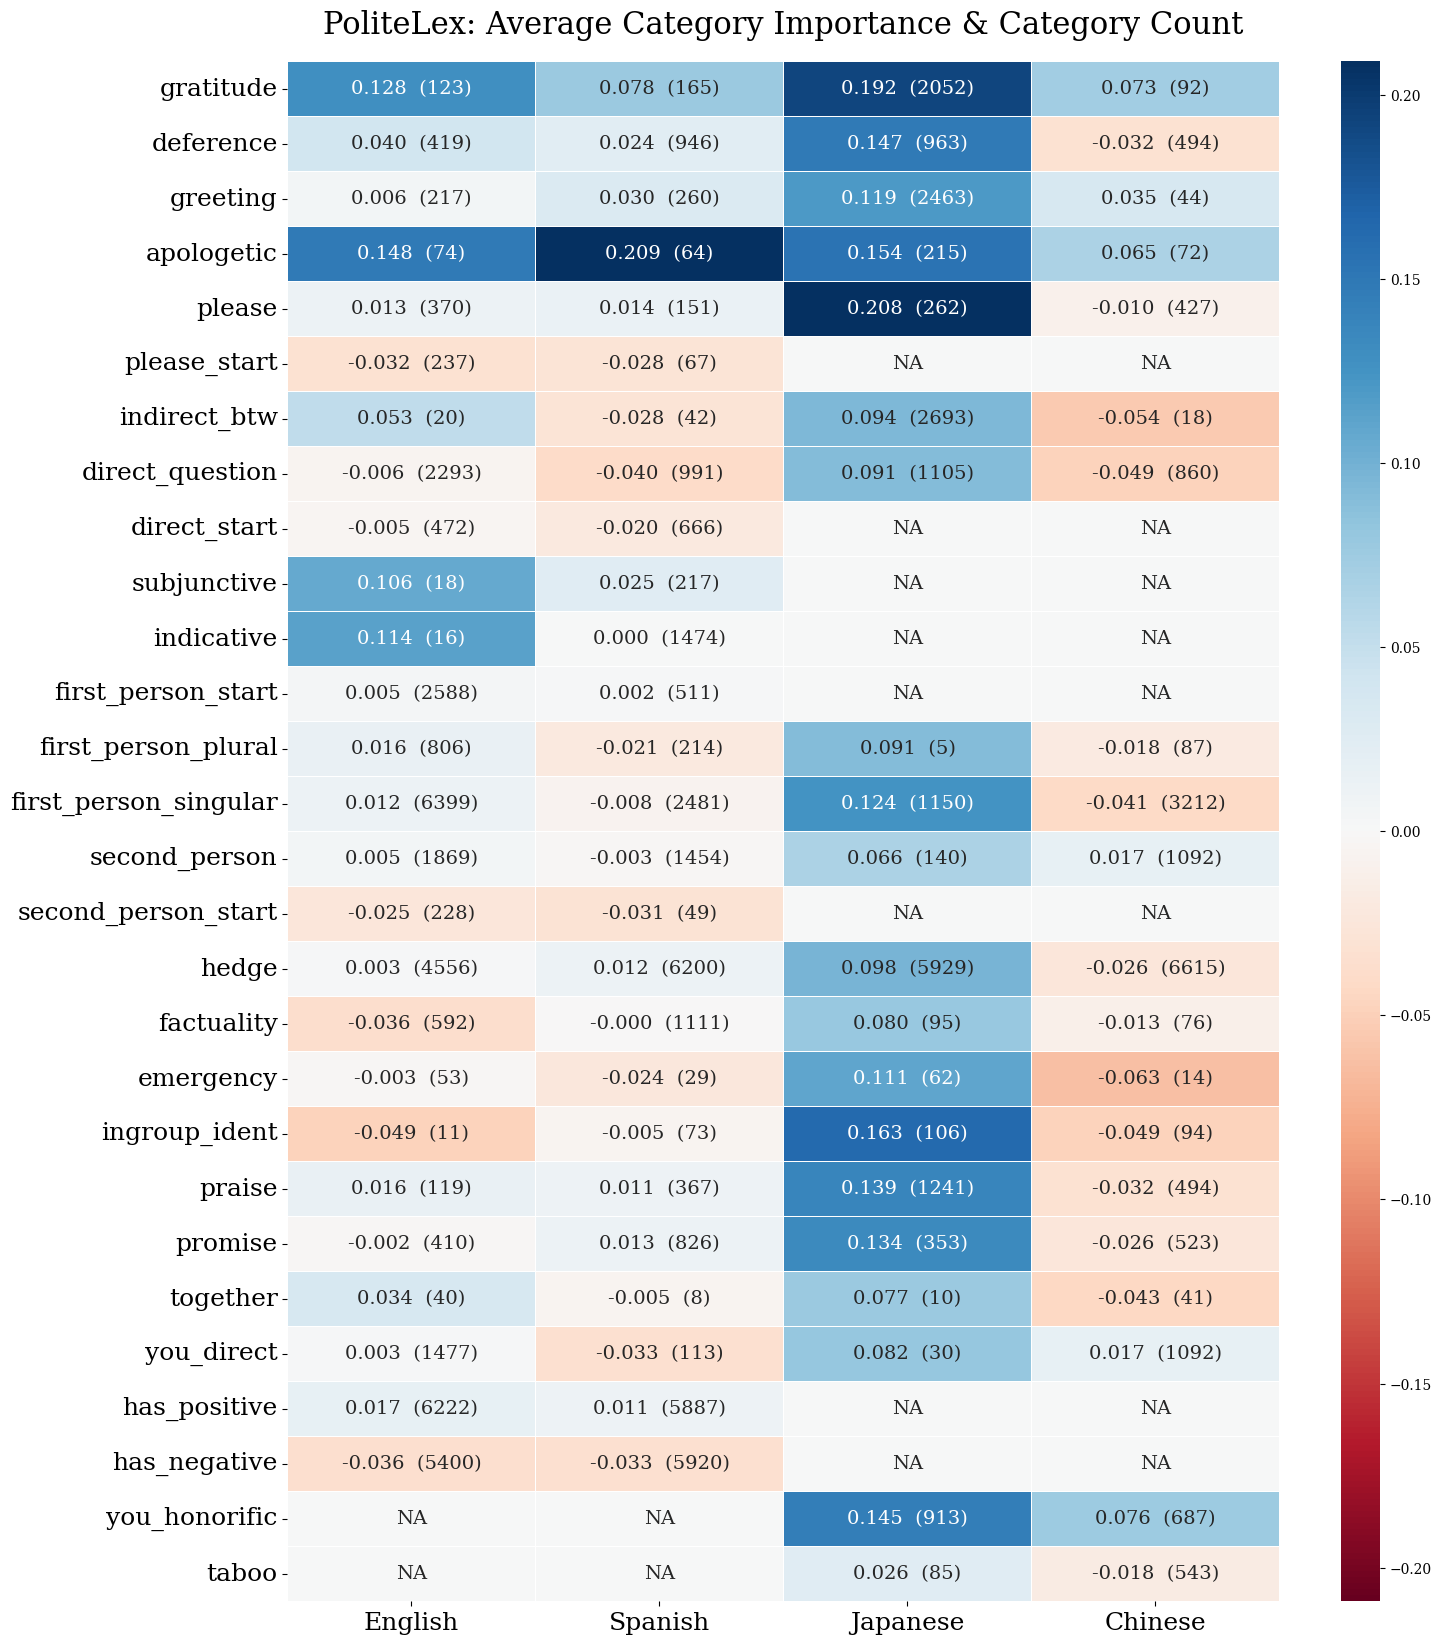

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

#get average of sentence lengths for all languages
en_lengths_avg = np.average([len(x[0]) for x in shap_en])
es_lengths_avg = np.average([len(x[0]) for x in shap_es])
zh_lengths_avg = np.average([len(x[0]) for x in shap_zh])
ja_lengths_avg = np.average([len(x[0]) for x in shap_ja])

en_values = strategies_english.copy()
es_values = strategies_spanish.copy()
zh_values = strategies_chinese.copy()
ja_values = strategies_japanese.copy()

en_counts = strategies_english_raw[1]
es_counts = strategies_spanish_raw[1]
zh_counts = strategies_chinese_raw[1]
ja_counts = strategies_japanese_raw[1]

all_keys = set(list(en_values.keys()) + list(es_values.keys()) + list(zh_values.keys()) + list(ja_values.keys()))
for key in all_keys:
    if(key not in en_values.keys()):
        en_values[key] = 0
        en_counts[key] = 0
    if(key not in es_values.keys()):
        es_values[key] = 0
        es_counts[key] = 0
    if(key not in zh_values.keys()):
        zh_values[key] = 0
        zh_counts[key] = 0
    if(key not in ja_values.keys()):
        ja_values[key] = 0
        ja_counts[key] = 0
        
df = pd.DataFrame([en_values, es_values, ja_values, zh_values], 
                   index=["English", "Spanish", "Japanese", "Chinese"])

value_to_label_map = {}
for key in en_values.keys():
    to_iterate = [en_values, es_values, ja_values, zh_values]
    counts_to_iterate = [en_counts, es_counts, ja_counts, zh_counts]
    for idx, _ in enumerate(to_iterate):
        val = to_iterate[idx][key]
        count = counts_to_iterate[idx][key]
        #format val to string with 3 sig figs
        val_string = "{:.3f}".format(val)
        count_string = "{:.0f}".format(count)
        label = val_string + "  (" + count_string + ")"
        value_to_label_map[val] = label

labels = (df.T).applymap(lambda v: 'NA' if v == 0 else value_to_label_map[v])
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(16, 20))
plt.title("PoliteLex: Average Category Importance & Category Count", fontsize=22, pad=20)
sns.heatmap(df.T, annot=labels, 
            cmap="RdBu", 
            vmin=-np.max(df.max()) , 
            vmax=np.max(df.max()), 
            annot_kws={"size": 14, 'verticalalignment': 'center', 'horizontalalignment': 'left'}, 
            cbar_kws={'aspect': 40}, 
            linewidths=0.5, 
            fmt = '')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()



### Visualization: Selected Strategies

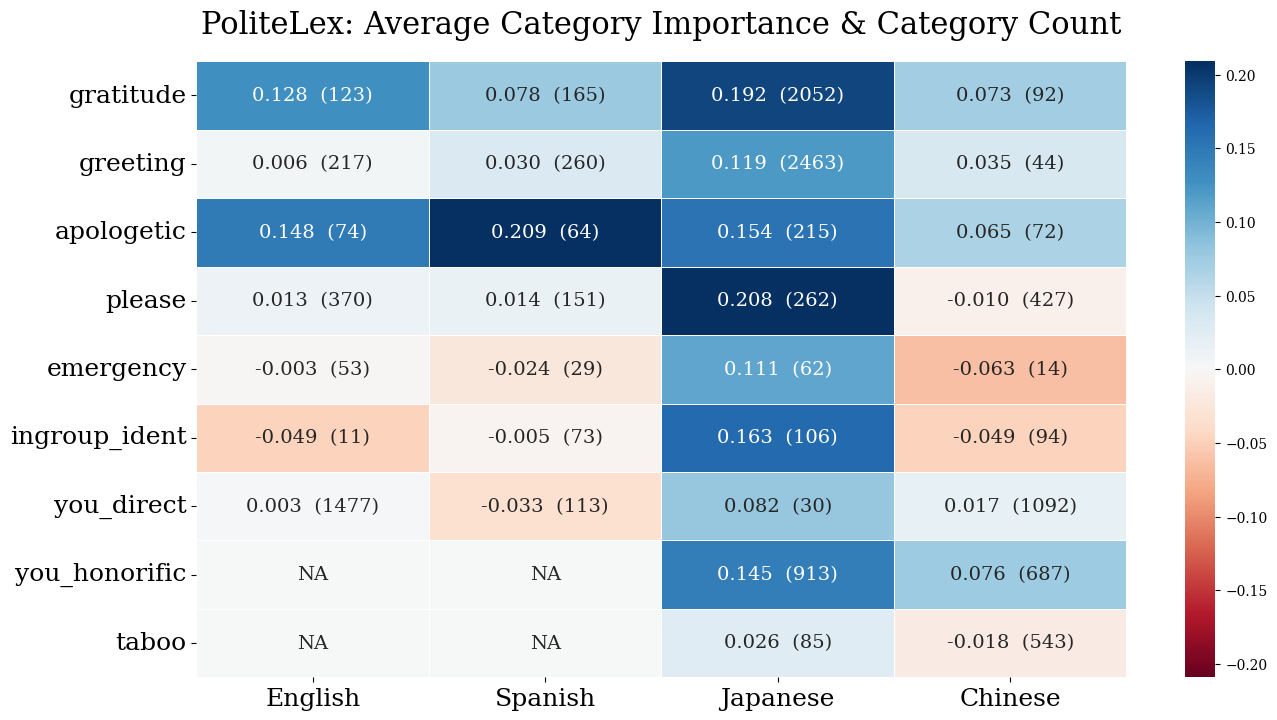

In [87]:
keys_to_keep = ["please", "gratitude", "apologetic", "greeting", "emergency", "ingroup_ident", "you_direct", "you_honorific", "taboo"]

en_values_trimmed = {k: v for k, v in en_values.items() if k in keys_to_keep}
es_values_trimmed = {k: v for k, v in es_values.items() if k in keys_to_keep}
ja_values_trimmed = {k: v for k, v in ja_values.items() if k in keys_to_keep}
zh_values_trimmed = {k: v for k, v in zh_values.items() if k in keys_to_keep}

en_counts_trimmed = {k: v for k, v in en_counts.items() if k in keys_to_keep}
es_counts_trimmed = {k: v for k, v in es_counts.items() if k in keys_to_keep}
ja_counts_trimmed = {k: v for k, v in ja_counts.items() if k in keys_to_keep}
zh_counts_trimmed = {k: v for k, v in zh_counts.items() if k in keys_to_keep}


value_to_label_map = {}
for key in keys_to_keep:
    to_iterate = [en_values_trimmed, es_values_trimmed, ja_values_trimmed, zh_values_trimmed]
    counts_to_iterate = [en_counts_trimmed, es_counts_trimmed, ja_counts_trimmed, zh_counts_trimmed]
    for idx, _ in enumerate(to_iterate):
        val = to_iterate[idx][key]
        count = counts_to_iterate[idx][key]
        #format val to string with 3 sig figs
        val_string = "{:.3f}".format(val)
        count_string = "{:.0f}".format(count)
        label = val_string + "  (" + count_string + ")"
        value_to_label_map[val] = label

df = pd.DataFrame([en_values_trimmed, es_values_trimmed, ja_values_trimmed, zh_values_trimmed], 
                   index=["English", "Spanish", "Japanese", "Chinese"])

labels = (df.T).applymap(lambda v: 'NA' if v == 0 else value_to_label_map[v])
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(15, 8))
plt.title("PoliteLex: Average Category Importance & Category Count", fontsize=22, pad=20)
sns.heatmap(df.T, annot=labels, 
            cmap="RdBu", 
            vmin=-np.max(df.max()) , 
            vmax=np.max(df.max()), 
            annot_kws={"size": 14, 'verticalalignment': 'center', 'horizontalalignment': 'left'}, 
            cbar_kws={'aspect':20}, 
            linewidths=0.5, 
            fmt = '')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

## Descriptive Statistics

In [ ]:
#get average of sentence lengths for all languages
en_lengths_avg = np.average([len(x) for x in utterances_en])
es_lengths_avg = np.average([len(x) for x in utterances_es])
zh_lengths_avg = np.average([len(x) for x in utterances_zh])
ja_lengths_avg = np.average([len(x) for x in utterances_ja])

#print all
print("Sentence Lengths:")
print("English: " + str(en_lengths_avg))
print("Spanish: " + str(es_lengths_avg))
print("Chinese: " + str(zh_lengths_avg))
print("Japanese: " + str(ja_lengths_avg))

#load pickle files
shap_en_test = shap_pickle = read_shap_values_pickle(prefix+"english.p")
shap_es_test = shap_pickle = read_shap_values_pickle(prefix+"spanish.p")
shap_ja_test = shap_pickle = read_shap_values_pickle(prefix+"japanese.p")
shap_zh_test = shap_pickle = read_shap_values_pickle(prefix+"chinese.p")

#get average base values
base_en_avg = np.average(shap_en_test.base_values)
base_es_avg = np.average(shap_es_test.base_values)
base_ja_avg = np.average(shap_ja_test.base_values)
base_zh_avg = np.average(shap_zh_test.base_values)

#get average values
shap_en_avg = np.average([np.sum(x) for x in shap_en_test.values])
shap_es_avg = np.average([np.sum(x) for x in shap_es_test.values])
shap_ja_avg = np.average([np.sum(x) for x in shap_ja_test.values])
shap_zh_avg = np.average([np.sum(x) for x in shap_zh_test.values])

#get min and max values
shap_en_max = np.max([np.sum(x) for x in shap_en_test.values])
shap_es_max = np.max([np.sum(x) for x in shap_es_test.values])
shap_ja_max = np.max([np.sum(x) for x in shap_ja_test.values])
shap_zh_max = np.max([np.sum(x) for x in shap_zh_test.values])

shap_en_min = np.min([np.sum(x) for x in shap_en_test.values])
shap_es_min = np.min([np.sum(x) for x in shap_es_test.values])
shap_ja_min = np.min([np.sum(x) for x in shap_ja_test.values])
shap_zh_min = np.min([np.sum(x) for x in shap_zh_test.values])

#print all
print("\nAverage Base Value and Average Shapley Value Sums:")
print("English: avg base_val: " + str(base_en_avg) + ", avg shap_val: " + str(shap_en_avg) + ", avg sum: " + str(base_en_avg + shap_en_avg))
print("Spanish: avg base_val: " + str(base_es_avg) + ", avg shap_val: " + str(shap_es_avg) + ", avg sum: " + str(base_es_avg + shap_es_avg))
print("Chinese: avg base_val: " + str(base_zh_avg) + ", avg shap_val: " + str(shap_zh_avg) + ", avg sum: " + str(base_zh_avg + shap_zh_avg))
print("Japanese: avg base_val: " + str(base_ja_avg) + ", avg shap_val: " + str(shap_ja_avg) + ", avg sum: " + str(base_ja_avg + shap_ja_avg))

#print max and min
print("\nMax and Min Shapley Values:")
print("English: " + "max: " + str(shap_en_max) + ", min: " + str(shap_en_min))
print("Spanish: " + "max: " + str(shap_es_max) + ", min: " + str(shap_es_min))
print("Chinese: " + "max: " + str(shap_zh_max) + ", min: " + str(shap_zh_min))
print("Japanese: " + "max: " + str(shap_ja_max) + ", min: " + str(shap_ja_min))


Sentence Lengths:
English: 259.4405263157895
Spanish: 273.63151430075453
Chinese: 75.80894736842106
Japanese: 77.40989647306544

Average Base Value and Average Shapley Value Sums:
English: avg base_val: -0.8182460504874849, avg shap_val: 0.922519341765561, avg sum: 0.10427329127807616
Spanish: avg base_val: 0.025704937318397264, avg shap_val: 0.01698058582791486, avg sum: 0.042685523146312125
Chinese: avg base_val: -0.07321098817218291, avg shap_val: -0.06879549633466492, avg sum: -0.14200648450684783
Japanese: avg base_val: 0.016116674690079033, avg shap_val: 0.32228744419619354, avg sum: 0.3384041188862726

Max and Min Shapley Values:
English: max: 3.2741998434066772, min: -1.5437759757041931
Spanish: max: 1.4448566287755964, min: -1.8033011555671692
Chinese: max: 2.3324123919010167, min: -2.129470158368349
Japanese: max: 1.6903726235032084, min: -1.6949101798236368


## Insights into Detected Strategies

In [ ]:
def get_insights(raw_strategies):
    #get average shap val of each word in each strategy
    insights = raw_strategies[2]
    insights_avg = {x:{} for x in insights.keys()}
    for strat in insights.keys():
        print("\n-----" + strat.upper() + "-----")
        for match in insights[strat]:
            avg = np.average(insights[strat][match])
            insights_avg[strat][match] = avg
        #sort insights_avg by count
        insights_avg[strat] = {k: v for k, v in sorted(insights_avg[strat].items(), key=lambda item: -len(insights[strat][item[0]]))}
        for match in insights_avg[strat]:
            #round median and avg to 5 dec pts
            median = round(np.median(insights[strat][match]), 5)
            avg = round(np.average(insights[strat][match]), 5)
            print(match + ": " + str(avg) + ", median: " + str(median) + ", count: " + str(len(insights[strat][match])))

get_insights(strategies_spanish_raw)


-----APOLOGETIC-----
lo siento: -0.00487, median: -0.00284, count: 17
perdón: 0.14788, median: 0.12969, count: 17
disculpa: 0.70845, median: 0.67712, count: 9
perdona: 0.25002, median: 0.30783, count: 9
excusa: -0.02272, median: -0.01146, count: 4
mis disculpas: 0.48309, median: 0.36523, count: 3
perdone: -0.07853, median: -0.07853, count: 2
disculpo: 0.1895, median: 0.1895, count: 2
disculpe: 0.74745, median: 0.74745, count: 1

-----DEFERENCE-----
bien: 0.01399, median: 0.00839, count: 411
bueno: 0.00125, median: -0.00096, count: 187
gran: -0.00119, median: 0.00377, count: 121
buena: 0.01971, median: 0.0105, count: 76
interesante: 0.05254, median: 0.03361, count: 64
perfectamente: 0.0157, median: 0.00868, count: 31
excelente: 0.04774, median: 0.00515, count: 17
increíble: -0.01423, median: -0.0124, count: 8
frío: 0.00907, median: 0.00593, count: 6
calor: 0.00939, median: 0.00884, count: 5
bonito: -0.07949, median: -0.01818, count: 4
bién: -0.05369, median: -0.05765, count: 3
genial: 